In [118]:
from cProfile import label
import cv2
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from IPython.display import Image

#### MAL1-A23 Group 9 Project
Members: Maxim Zavidei (304321), Yoana Miteva (304132)<br/>
Dataset: [GTSRB - German Traffic Sign Recognition Benchmark](https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/data) 

#### 1-2. Frame the problem and look at the big picture & get the data
#### Description of the dataset:
The chosen dataset of the project is the [German Traffic Sign Recognition Benchmark](https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/data).<br/>
It contains over 50 000 images categorized in 43 unique types of road traffic signs. It is also provides a rich context of pictures for each kind of traffic sign, meaning that it offers pictures ranging from day-time to night-time, with different types of weather conditions and varying levels of image sharpness.
It's a pretty popular dataset first published at the International Joint Conference on Neural Networks (IJCNN) 2011.

#### 3. Explore and visualize the data to gain insights.
#### Structure of the dataset:
The dataset is located under the folder "gtsrb" and is split into 43 sub-folders (as shown in the image below). Each sub-folder represents a type/category of a traffic sign, and inside each sub-folder is located a long list of varying illustrations of that type of traffic sign.

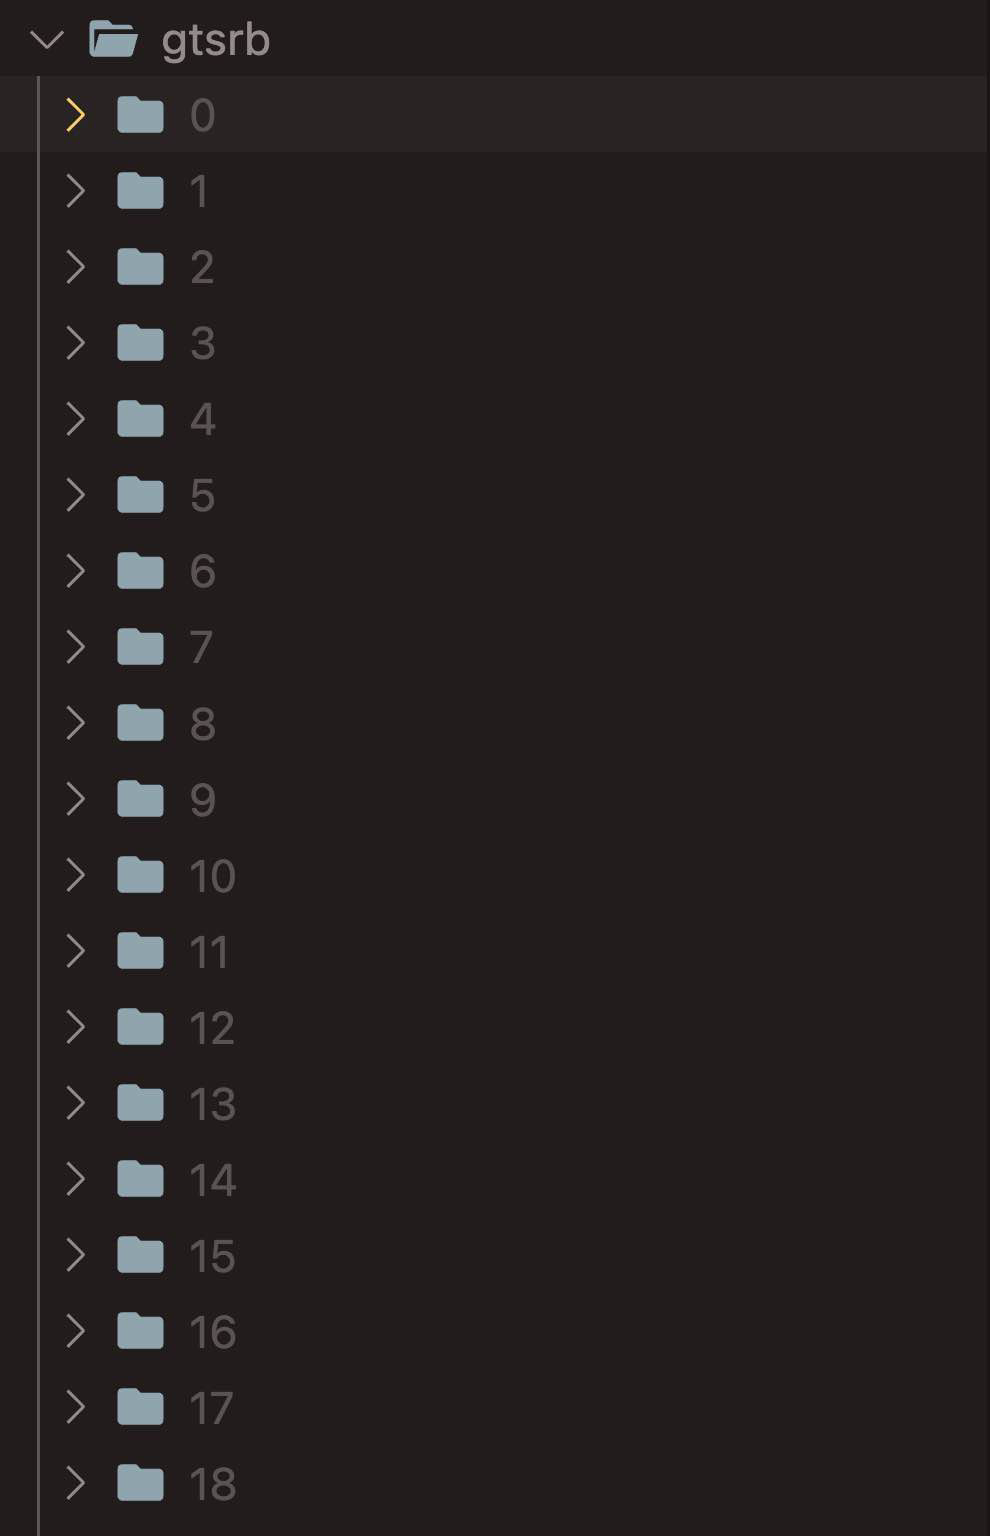

In [119]:
# Structure of the dataset:
Image('https://cdn.mathpix.com/snip/images/pMu1aallDJUHI8_mWgiGkg7ktHoq1grB25-uGow349g.original.fullsize.png', width = 200)

The picture below illustrates all of the 43 types/categories of traffic signs that the dataset contains. The sign types range from different speed limits, mandatory signs to some examples of danger signs and a few unique signs like the priority or stop signs. 

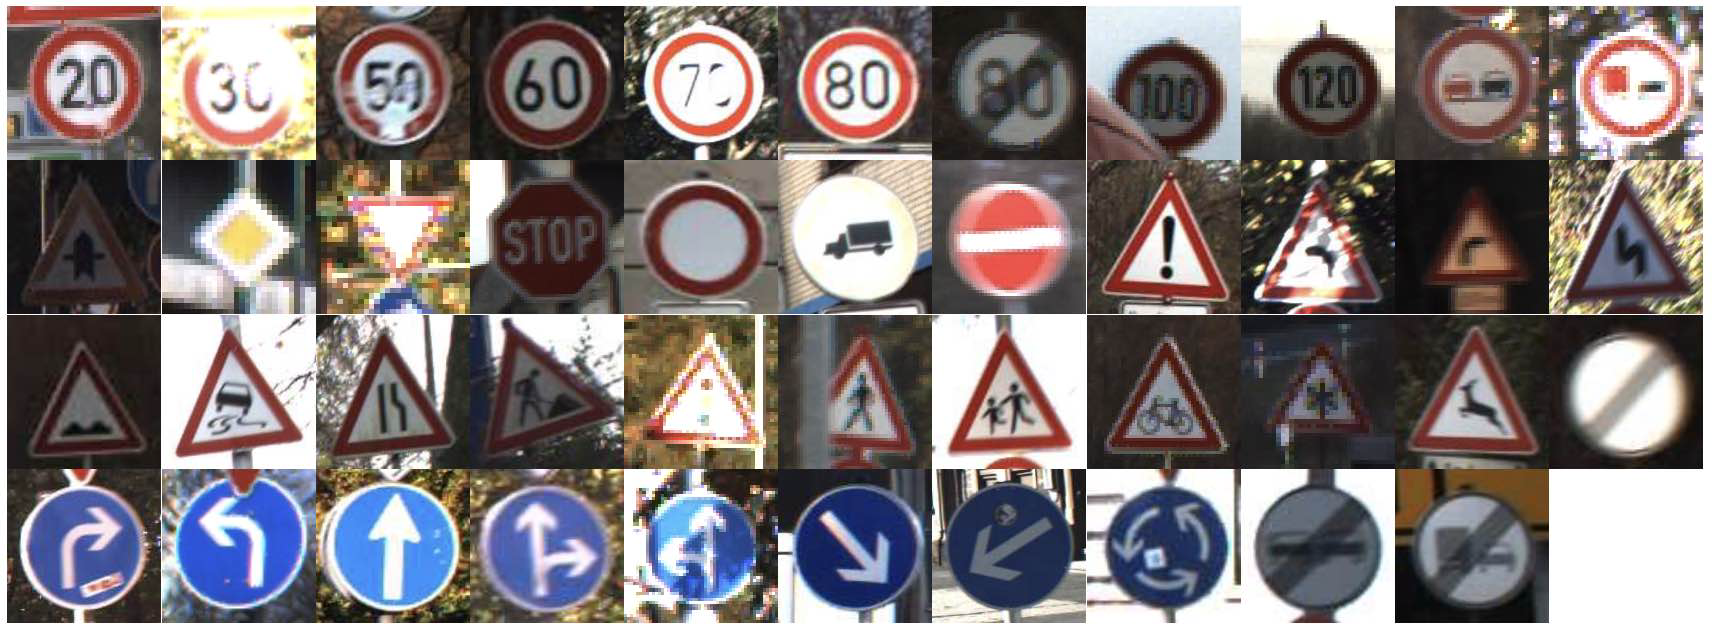

In [120]:
# All 43 types/categories of traffic sign (pictures from the dataset):
Image('https://cdn.mathpix.com/snip/images/NP56VMm4HmLkMkeuAEQt6AzJrlzJSYC0y5eGQhtyfnc.original.fullsize.png', width = 800)

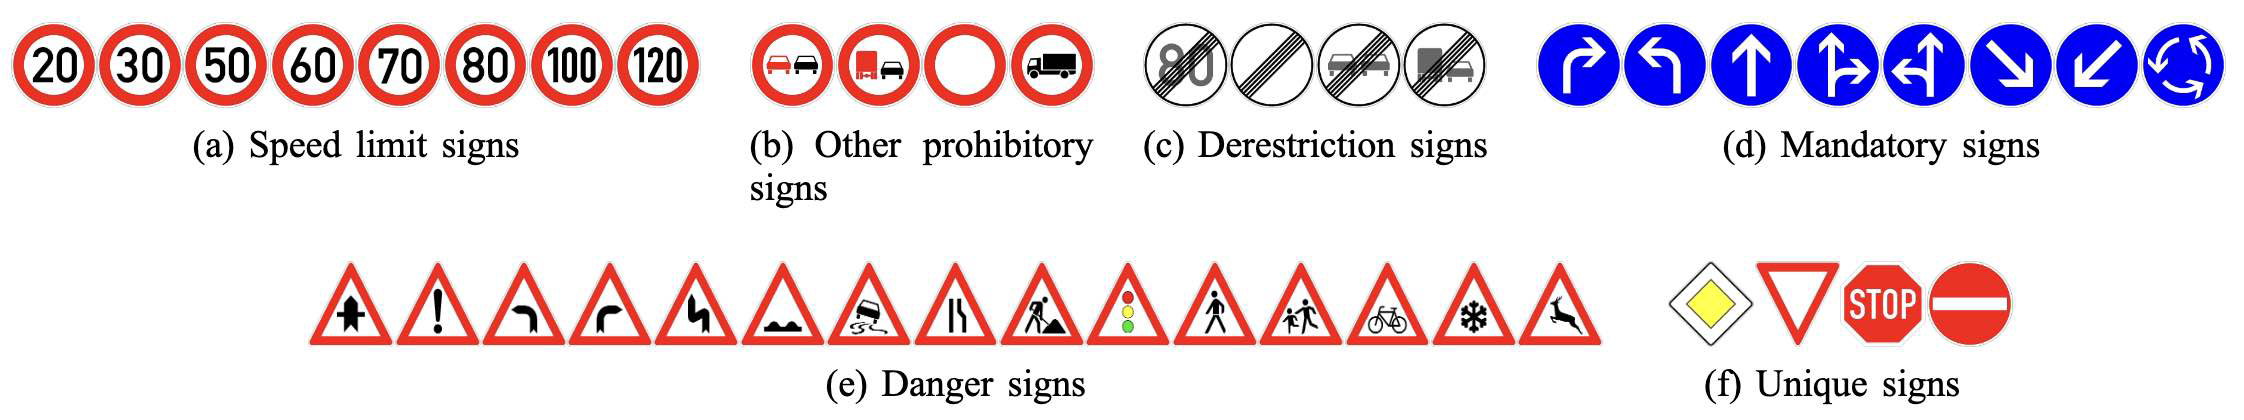

In [121]:
# All 43 types/categories of traffic sign (standardized representations of the signs):
Image('https://cdn.mathpix.com/snip/images/o3GtyOtItbFze4t_cFndeZGpG1PuXR0tjth7NqEjkDM.original.fullsize.png', width = 800)

#### Second dataset (collected by the group):
In order to make the group project more practical and interesting the group went outside VIA University and collected images of relevant signs placed on the surrounding streets. In the latter part of the project after training the model the collected images will be used to evaluate how well the obtained model performs.

The second set of images can be found under the folder collected_images.

#### 4-5. Prepare the data to better expose the underlying data patterns to machine learning algorithms.
#### Explore many different models and short-list the best ones.
#### SVM based approach:

In [139]:
# Data loading parameters
DATA_DIR = './gtsrb'
NUM_CATEGORIES = 43
IMG_WIDTH = 30
IMG_HEIGHT = 30

# Function to extract color histogram features
def extract_features(image, bins=(8, 8, 8)):
    # Compute a histogram for each color channel
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    # Normalize the histogram
    cv2.normalize(hist, hist)
    return hist.flatten()

# Load and preprocess data
images = []
labels = []
for i in range(NUM_CATEGORIES):
    for filename in os.listdir(os.path.join(DATA_DIR, str(i))):
        file_path = os.path.join(DATA_DIR, str(i), filename)
        img = cv2.imread(file_path)
        if img is not None:
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            features = extract_features(img)
            images.append(features)
            labels.append(i)

images = np.array(images)
labels = np.array(labels)

# Splitting the dataset into training and testing sets
TEST_SIZE = 0.4
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=TEST_SIZE)

# Feature Scaling
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Create an SVM classifier
clf = svm.SVC(kernel='linear')  # You can experiment with different kernels

# Train the classifier
clf.fit(x_train, y_train)

# Make predictions
predictions = clf.predict(x_test)

# Evaluation
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')

print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")


Accuracy: 0.47766516516516516, Precision: 0.5277313442406301, Recall: 0.47766516516516516


#### Convolutional neural network approach:
#### Data loading:

In [ ]:
# Path to the root folder containing the dataset:
DATA_DIR = './gtsrb'

# Number of sub-folders, which also represents the number of traffic sign categories:
NUM_CATEGORIES = 43

# Resize all the images with the following parameters:
IMG_WIDTH = 30
IMG_HEIGHT = 30

images = []
labels = []
for i in range(NUM_CATEGORIES):
    for filename in os.listdir(os.path.join(DATA_DIR, str(i))):
        file_path = os.path.join(os.path.join(DATA_DIR, str(i)), filename)
        img = cv2.imread(file_path)
        if img is not None:
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            images.append(img)
            labels.append(i)

#### 6. Constructing the neural network and fine-tuning it:

In [123]:
# The proportion with which to split the training data nad test data
TEST_SIZE = 0.4

# Split data into training and testing sets
labels = tf.keras.utils.to_categorical(labels)
x_train, x_test, y_train, y_test = train_test_split(
    np.array(images), np.array(labels), test_size=TEST_SIZE
)

# The model uses a sequential API from Keras, meaning that layers are added in sequence.
model = tf.keras.models.Sequential([
    
    # Sets the input shape of the network to match the dimensions of how the images were loaded from the GTSRB dataset.
    # The second parameter '3' indicates that the images are in color (RGB channels).
    tf.keras.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)),


    # First Convolutional Layer
    # This layer creates 32 filters (kernels), each of size 3x3, with ReLU (Rectified Linear Unit) activation.
    # It is used to detect features like edges, colors, gradients, etc.
    tf.keras.layers.Conv2D(32, 3, activation="relu"),

    # This layer reduces the spatial dimensions (width, height) of the output from the previous layer.
    # It helps in reducing the computation and the number of parameters.
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),


    # Second Convolutional Layer
    # These layers further process the features extracted by the previous layers, 
    # helping the network to understand more complex patterns in the data e.g. different types of arrows on the traffic signs
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # This layer flattens the 2D arrays outputted by the previous layers into a single long vector.
    # It's necessary to transition from the convolutional layers to the fully connected layers.
    tf.keras.layers.Flatten(),

    # A fully connected layer that takes the flattened input and outputs 128 nodes.
    # It helps in making decisions based on the features extracted by convolutional layers.
    tf.keras.layers.Dense(128, activation="relu"),

    # This layer randomly sets input units to 0 with a frequency of 0.5 at each step during training, which helps prevent overfitting.
    tf.keras.layers.Dropout(0.5),

    # The final layer has a node for each category (traffic sign type) in the dataset
    # and uses softmax activation to output a probability distribution over the categories.
    tf.keras.layers.Dense(NUM_CATEGORIES, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(),
    ]
)

#### Training the neural network:

In [124]:
# For how many epochs to train the neural network
EPOCHS = 10

# Fit model on training data
model.fit(x_train, y_train, epochs=EPOCHS)

# Evaluate neural network performance
model.evaluate(x_test,  y_test, verbose=2)

Epoch 1/10
500/500 [==============================] - 4s 7ms/step - loss: 3.3382 - accuracy: 0.2354 - precision_6: 0.6835 - recall_6: 0.1010 - auc_6: 0.8064
Epoch 2/10
500/500 [==============================] - 3s 7ms/step - loss: 1.6349 - accuracy: 0.5174 - precision_6: 0.8176 - recall_6: 0.3555 - auc_6: 0.9554
Epoch 3/10
500/500 [==============================] - 3s 7ms/step - loss: 1.0786 - accuracy: 0.6653 - precision_6: 0.8425 - recall_6: 0.5402 - auc_6: 0.9789
Epoch 4/10
500/500 [==============================] - 3s 6ms/step - loss: 0.7655 - accuracy: 0.7650 - precision_6: 0.8758 - recall_6: 0.6734 - auc_6: 0.9874
Epoch 5/10
500/500 [==============================] - 3s 6ms/step - loss: 0.6116 - accuracy: 0.8118 - precision_6: 0.8956 - recall_6: 0.7436 - auc_6: 0.9908
Epoch 6/10
500/500 [==============================] - 3s 6ms/step - loss: 0.5023 - accuracy: 0.8450 - precision_6: 0.9051 - recall_6: 0.7945 - auc_6: 0.9926
Epoch 7/10
500/500 [==============================] - 3s 6

[0.09849812835454941,
 0.9755067825317383,
 0.9822756052017212,
 0.9673423171043396,
 0.9987803101539612]

#### 7. Presenting the solution and discussion of results:
1) Loss: 9.85%<br/>
This tells us how well the model is doing in terms of making predictions for the validation set. A loss of 0.0985 is low, indicating that the model's predictions are quite close to the actual values. It also suggests that the model has generalized well from the training data to unseen data. Looking at it's progression through the epochs it initially started as 3.3382, until and got down to 0.0985 which demonstrates significant learning and improvement over the epochs.

2) Accuracy: 97.55%<br/>
This indicates that the model correctly classified about 97.55% of the validation set and means that the model is performing well in distinguishing between different classes.

3) Precision: 98.23%<br/>
Precision is the ratio of correctly predicted positive observations to the total predicted positives. A precision of 98.23% means that when the model predicts a class, it is correct 98.23% of the time.

4) Recall: 96.73%<br/>
Recall (or Sensitivity) measures the ratio of correctly predicted positive observations to all observations in actual class. A recall of 96.73 implies that the model successfully identifies 96.73 of all actual positives. High recall is especially useful in situations where missing a positive is costly.

5) AUC: 99.87%<br/>
The Area Under the Curve (AUC) of the Receiver Operating Characteristic (ROC) is near perfect. This score means that the model has an excellent measure of separability and is almost always able to distinguish between different classes correctly.

#### Testing the model on the custom dataset:

In [125]:
# Helper functions

"""
Displays an image in a Jupyter notebook.
"""
def display_image(image_path):
    img = cv2.imread(image_path)
    # Convert from BGR (OpenCV default) to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Display the image
    plt.imshow(img_rgb)
    plt.axis('off')  # Turn off axis numbers
    plt.show()

"""
    Loads an image from a given path and pre-processes it to fit the model.
    """
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = np.array(img)
    img = np.expand_dims(img, axis=0)  # Add a batch dimension
    return img

"""
Predicts the category of the image at the given path.
"""
def predict_category(image_path, model):
    img = load_and_preprocess_image(image_path)
    predictions = model.predict(img)
    predicted_category = np.argmax(predictions)
    return predicted_category

#### Example 1:

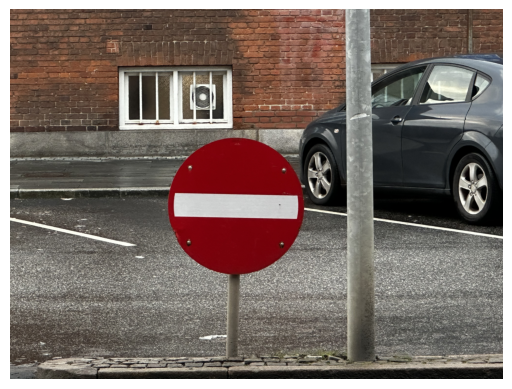

In [126]:
image_path = 'collected_images/IMG_0636_RAW.jpg'
display_image(image_path)

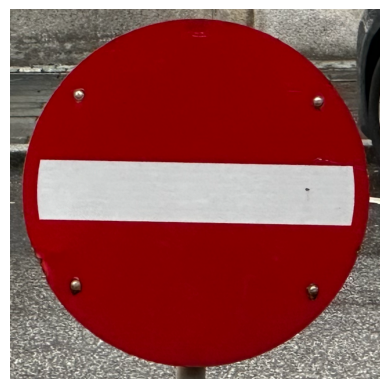

1/1 [==============================] - 0s 30ms/step
The predicted category is: 17


In [127]:
image_path = 'collected_images/IMG_0636_CROPPED.png'
display_image(image_path)

predicted_category = predict_category(image_path, model)
print(f"The predicted category is: {predicted_category}")

#### Example 2:

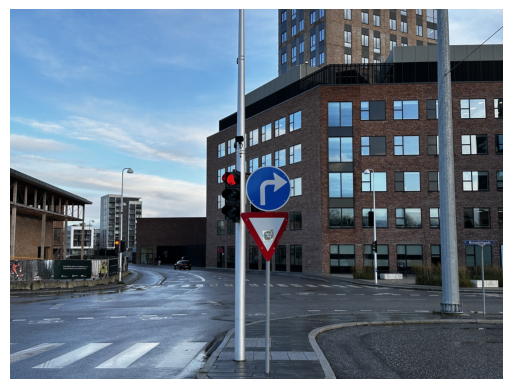

In [128]:
image_path = 'collected_images/IMG_0644_RAW.jpg'
display_image(image_path)

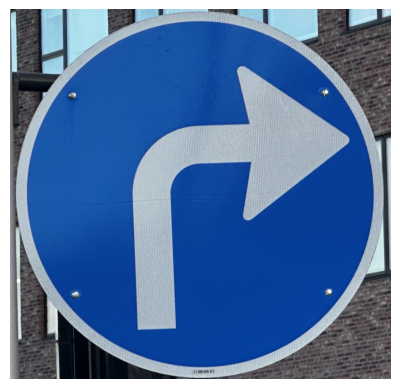

1/1 [==============================] - 0s 10ms/step
The predicted category is: 33


In [129]:
image_path = 'collected_images/IMG_0644_CROPPED.png'
display_image(image_path)

predicted_category = predict_category(image_path, model)
print(f"The predicted category is: {predicted_category}")

#### Example 3:

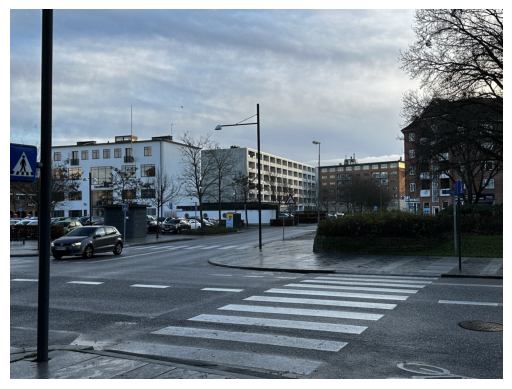

In [130]:
image_path = 'collected_images/IMG_0653_RAW.jpg'
display_image(image_path)

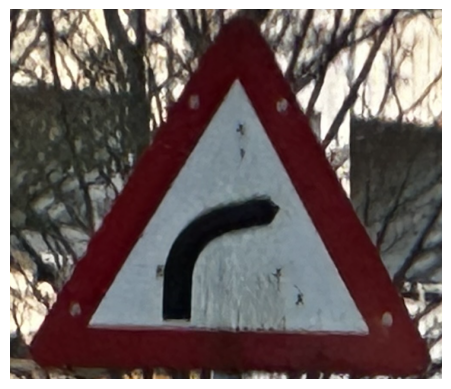

1/1 [==============================] - 0s 10ms/step
The predicted category is: 20


In [131]:
image_path = 'collected_images/IMG_0653_CROPPED.png'
display_image(image_path)

predicted_category = predict_category(image_path, model)
print(f"The predicted category is: {predicted_category}")

#### Example 4:

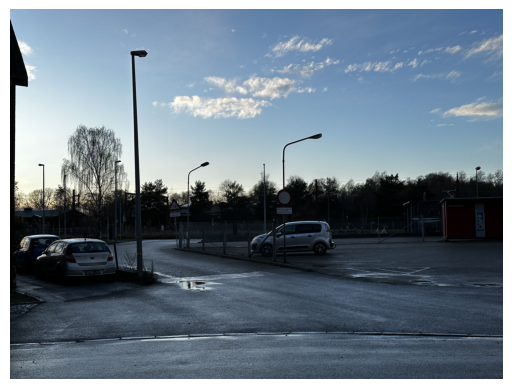

In [132]:
image_path = 'collected_images/IMG_0661_RAW.jpg'
display_image(image_path)

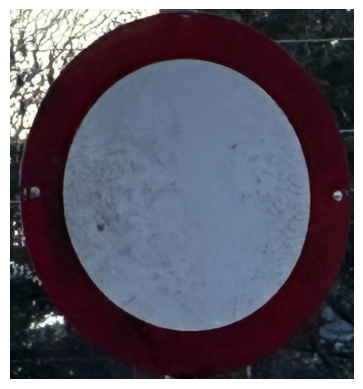

1/1 [==============================] - 0s 10ms/step
The predicted category is: 9


In [133]:
image_path = 'collected_images/IMG_0661_CROPPED.png'
display_image(image_path)

predicted_category = predict_category(image_path, model)
print(f"The predicted category is: {predicted_category}")

#### Example 5:

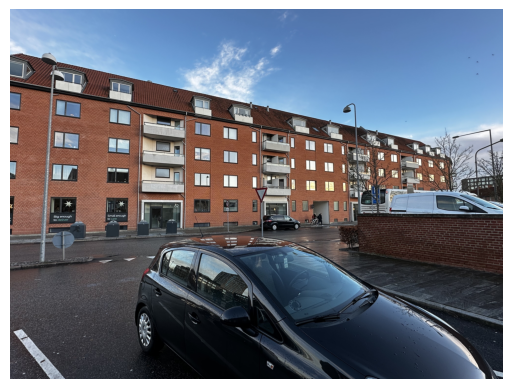

In [134]:
image_path = 'collected_images/IMG_0665_RAW.jpg'
display_image(image_path)

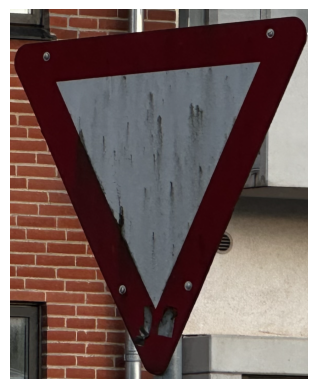

1/1 [==============================] - 0s 11ms/step
The predicted category is: 13


In [135]:
image_path = 'collected_images/IMG_0665_CROPPED.png'
display_image(image_path)

predicted_category = predict_category(image_path, model)
print(f"The predicted category is: {predicted_category}")